# NeuMF++ Recommendation System with Autoencoder Embeddings

This notebook implements a recommendation system based on the NeuMF++ approach (Ong et al., 2021), which combines:
1. Neural Collaborative Filtering (user-item interactions)
2. Stacked Denoising Autoencoder (SDAE) for rich item representations
3. Content-based features from product metadata

The model is especially effective for cold-start scenarios where products have limited interaction data.

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import gzip
from IPython.display import display

In [ ]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [ ]:
reviews_df = pd.read_csv("/content/drive/My Drive/bt4222data/Reviews Data Cleaned/cleaned_reviews.csv", keep_default_na=False)

In [ ]:
# Extract unique users and items
unique_users = reviews_df['reviewerID'].unique()
unique_items = reviews_df['asin'].unique()

print(f"Number of unique users: {len(unique_users)}")
print(f"Number of unique items: {len(unique_items)}")

Number of unique users: 192403
Number of unique items: 63001


In [ ]:
# Load pre-computed BERT embeddings
embeddings_path = "/content/drive/My Drive/bt4222data/embeddings/filtered_metadata_embeddings.npz"
loaded_data = np.load(embeddings_path)
product_embeddings = loaded_data['embeddings']
print(f"Loaded embeddings shape: {product_embeddings.shape}")

Loaded embeddings shape: (63001, 384)


In [ ]:
# Verify that embeddings align with unique items in reviews
assert product_embeddings.shape[0] == len(unique_items), "Number of embeddings and reviews items don't match"

## Model Architectures

We'll implement two main components:
1. **Stacked Denoising Autoencoder (SDAE)**: Compresses product embeddings into dense latent representations
2. **NeuMF++ Model**: Combines user-item interactions with SDAE embeddings for recommendations

### SDAE Architecture

In [ ]:
class SDAE(nn.Module):
    """
    Stacked Denoising Autoencoder for compressing item features.
    """
    def __init__(self, input_dim, hidden_dims, latent_dim, dropout_rate=0.2):
        super(SDAE, self).__init__()

        # Build encoder layers
        encoder_layers = []
        current_dim = input_dim

        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim)
            ])
            current_dim = hidden_dim

        # Final encoder layer to latent dimension
        encoder_layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim)
        ])

        self.encoder = nn.Sequential(*encoder_layers)

        # Build decoder layers (reverse of encoder)
        decoder_layers = []
        current_dim = latent_dim

        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim)
            ])
            current_dim = hidden_dim

        # Final decoder layer to original dimension
        decoder_layers.append(nn.Linear(current_dim, input_dim))

        self.decoder = nn.Sequential(*decoder_layers)
        self.dropout = nn.Dropout(dropout_rate)

    def add_noise(self, x):
        """Add dropout noise to the input for denoising"""
        return self.dropout(x)

    def encode(self, x):
        """Encode input to latent representation without noise"""
        return self.encoder(x)

    def forward(self, x):
        """Full forward pass with noise for training"""
        x_noisy = self.add_noise(x)
        latent = self.encoder(x_noisy)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

### NeuMF++ Model

In [ ]:
class NeuMFPlusPlus(nn.Module):
    """
    Neural Matrix Factorization++ Model combining NCF with autoencoder embeddings.
    """
    def __init__(self, num_users, num_items, embedding_dim=16, latent_dim=64, layers=[64, 32, 16]):
        super(NeuMFPlusPlus, self).__init__()

        # ID Embeddings for GMF and MLP
        self.user_embedding_gmf = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embedding_dim)
        self.user_embedding_mlp = nn.Embedding(num_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embedding_dim)

        # MLP layers
        mlp_layers = []
        input_dim = embedding_dim * 2 + latent_dim  # user + item embeddings + autoencoder latent

        for layer_dim in layers:
            mlp_layers.append(nn.Linear(input_dim, layer_dim))
            mlp_layers.append(nn.ReLU())
            input_dim = layer_dim

        self.mlp = nn.Sequential(*mlp_layers)

        # Final prediction layer
        self.final = nn.Linear(layers[-1] + embedding_dim, 1)  # MLP output + GMF output

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, std=0.01)

    def forward(self, user_indices, item_indices, item_sdae_embeddings):
        """Forward pass of NeuMF++"""
        # GMF path
        user_embedding_gmf = self.user_embedding_gmf(user_indices)
        item_embedding_gmf = self.item_embedding_gmf(item_indices)
        gmf_output = user_embedding_gmf * item_embedding_gmf

        # MLP path
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)

        # Get SDAE embeddings for the items
        item_sdae_batch = item_sdae_embeddings[item_indices]

        # Concatenate MLP inputs
        mlp_input = torch.cat([user_embedding_mlp, item_embedding_mlp, item_sdae_batch], dim=1)
        mlp_output = self.mlp(mlp_input)

        # Concatenate GMF and MLP outputs
        output = torch.cat([gmf_output, mlp_output], dim=1)

        # Final prediction
        prediction = self.final(output)

        return prediction

### Dataset Rating Class

In [ ]:
class RatingDataset(Dataset):
    """Dataset for training the NeuMF++ model with user-item interactions."""
    def __init__(self, interactions_df):
        self.user_indices = interactions_df['user_idx'].values
        self.item_indices = interactions_df['item_idx'].values
        self.ratings = interactions_df['overall'].values

    def __len__(self):
        return len(self.user_indices)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.user_indices[idx], dtype=torch.long),
            torch.tensor(self.item_indices[idx], dtype=torch.long),
            torch.tensor(self.ratings[idx], dtype=torch.float)
        )


# Training Functions

We'll define functions for:
- Training the autoencoder
- Generating latent embeddings
- Training the NeuMF++ model
- Evaluating model performance
- Generating recommendations

### AutoEncoder Trainng

In [ ]:
def train_autoencoder(model, embeddings, batch_size=128, num_epochs=20, learning_rate=0.001):
    """Train the autoencoder model."""
    # Convert to PyTorch tensors
    embeddings_tensor = torch.FloatTensor(embeddings)

    # Create dataset and dataloader
    dataset = TensorDataset(embeddings_tensor, embeddings_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    history = {'loss': []}

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            reconstructed, _ = model(inputs)

            # Compute loss
            loss = criterion(reconstructed, targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(dataset)
        history['loss'].append(avg_loss)

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

    return model, history


### Generate latent Embeddings

In [ ]:
def generate_latent_embeddings(model, embeddings):
    """Generate latent embeddings using the trained encoder."""
    model.eval()

    # Process in batches to avoid memory issues
    batch_size = 1024
    num_items = len(embeddings)
    num_batches = (num_items + batch_size - 1) // batch_size
    latent_embeddings = np.zeros((num_items, model.encoder[-2].out_features))

    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_items)

            batch_embeddings = torch.FloatTensor(embeddings[start_idx:end_idx]).to(device)
            batch_latent = model.encode(batch_embeddings).cpu().numpy()

            latent_embeddings[start_idx:end_idx] = batch_latent

    return latent_embeddings

### Training NeuMF++

In [ ]:
def train_neumf_plus_plus(model, train_dataloader, item_sdae_embeddings, epochs=20, learning_rate=0.001):
    """Train the NeuMF++ model for rating prediction."""
    # Move model and embeddings to device
    model = model.to(device)
    item_sdae_embeddings = torch.FloatTensor(item_sdae_embeddings).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training history
    history = {'loss': [], 'rmse': []}

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        total_rmse = 0.0
        total_samples = 0

        for user_indices, item_indices, ratings in train_dataloader:
            batch_size = user_indices.size(0)
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)
            ratings = ratings.to(device)

            # Forward pass
            predictions = model(user_indices, item_indices, item_sdae_embeddings).squeeze()

            # Compute loss
            loss = criterion(predictions, ratings)

            # Compute RMSE for this batch
            rmse = torch.sqrt(torch.mean((predictions - ratings) ** 2))

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_rmse += rmse.item() * batch_size
            total_samples += batch_size

        # Calculate average loss and RMSE for the epoch
        avg_loss = total_loss / total_samples
        avg_rmse = total_rmse / total_samples

        history['loss'].append(avg_loss)
        history['rmse'].append(avg_rmse)

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}, RMSE: {avg_rmse:.6f}')

    return model, history

### Evaluation Functions - RMSE and MAE

In [ ]:
def evaluate_model(model, test_dataloader, item_sdae_embeddings):
    """Evaluate the model on test data."""
    model.eval()
    item_sdae_embeddings = torch.FloatTensor(item_sdae_embeddings).to(device)

    all_predictions = []
    all_ratings = []

    with torch.no_grad():
        for user_indices, item_indices, ratings in test_dataloader:
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)

            # Forward pass
            predictions = model(user_indices, item_indices, item_sdae_embeddings).squeeze()

            # Store predictions and ratings
            all_predictions.extend(predictions.cpu().numpy())
            all_ratings.extend(ratings.numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_ratings = np.array(all_ratings)

    # Calculate metrics
    rmse = np.sqrt(np.mean((all_predictions - all_ratings) ** 2))
    mae = np.mean(np.abs(all_predictions - all_ratings))

    return {
        'RMSE': rmse,
        'MAE': mae
    }

### Evaluating Cold Start Items

In [ ]:
def evaluate_cold_start(reviews_df, model, mappings, item_sdae_embeddings, n_cold_items=100):
    """Evaluate the model's performance on cold-start items."""
    # Count interactions per item
    item_counts = reviews_df['asin'].value_counts().reset_index()
    item_counts.columns = ['asin', 'count']

    # Identify cold-start items (those with few interactions)
    cold_start_items = item_counts.sort_values('count').head(n_cold_items)['asin'].values
    print(f"Average interactions for cold-start items: {item_counts['count'][:n_cold_items].mean():.1f}")

    # Filter reviews for cold-start items
    cold_start_reviews = reviews_df[reviews_df['asin'].isin(cold_start_items)].copy()

    # Encode cold start reviews
    cold_start_reviews['user_idx'] = cold_start_reviews['reviewerID'].map(mappings['user_to_idx'])
    cold_start_reviews['item_idx'] = cold_start_reviews['asin'].map(mappings['item_to_idx'])

    # Create dataset and dataloader
    cold_start_dataset = RatingDataset(cold_start_reviews)
    cold_start_dataloader = DataLoader(cold_start_dataset, batch_size=128, shuffle=False)

    # Evaluate model on cold-start items
    model.eval()
    item_sdae_embeddings_tensor = torch.FloatTensor(item_sdae_embeddings).to(device)

    all_predictions = []
    all_ratings = []

    with torch.no_grad():
        for user_indices, item_indices, ratings in cold_start_dataloader:
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)

            # Forward pass
            predictions = model(user_indices, item_indices, item_sdae_embeddings_tensor).squeeze()

            # Store predictions and ratings
            all_predictions.extend(predictions.cpu().numpy())
            all_ratings.extend(ratings.numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_ratings = np.array(all_ratings)

    # Calculate metrics
    rmse = np.sqrt(np.mean((all_predictions - all_ratings) ** 2))
    mae = np.mean(np.abs(all_predictions - all_ratings))

    print(f"Cold-Start RMSE: {rmse:.4f}")
    print(f"Cold-Start MAE: {mae:.4f}")

    return {
        'cold_start_rmse': rmse,
        'cold_start_mae': mae,
        'num_cold_items': n_cold_items
    }

### Generate Recommendations

In [ ]:
def generate_recommendations(model, user_id, mappings, item_sdae_embeddings, top_k=5):
    """
    Generate top-k recommendations for a specific user.
    Returns only the product IDs.

    Args:
        model: Trained NeuMF++ model
        user_id: User ID to generate recommendations for
        mappings: Dictionary of user/item mappings
        item_sdae_embeddings: SDAE latent embeddings for items
        top_k: Number of recommendations to generate (default: 5)

    Returns:
        list: Top-k recommended product IDs
    """
    model.eval()

    # Convert user ID to index
    if user_id not in mappings['user_to_idx']:
        raise ValueError(f"User ID {user_id} not found in the dataset")

    user_idx = mappings['user_to_idx'][user_id]

    # Get all item indices
    all_item_indices = np.arange(mappings['num_items'])

    # Prepare inputs for the model
    user_indices = np.full_like(all_item_indices, user_idx)

    # Process in batches
    batch_size = 1024
    num_items = len(all_item_indices)
    num_batches = (num_items + batch_size - 1) // batch_size
    all_predictions = np.zeros(num_items)

    item_sdae_embeddings_tensor = torch.FloatTensor(item_sdae_embeddings).to(device)

    # Get predictions
    with torch.no_grad():
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_items)

            batch_user_indices = torch.tensor(user_indices[start_idx:end_idx], dtype=torch.long).to(device)
            batch_item_indices = torch.tensor(all_item_indices[start_idx:end_idx], dtype=torch.long).to(device)

            batch_predictions = model(batch_user_indices, batch_item_indices, item_sdae_embeddings_tensor).squeeze()
            all_predictions[start_idx:end_idx] = batch_predictions.cpu().numpy()

    # Get top-k items
    top_indices = np.argsort(-all_predictions)[:top_k]

    # Convert indices back to item IDs
    top_items = [mappings['idx_to_item'][idx] for idx in top_indices]

    return top_items

# Helper Functions

In [ ]:
def create_user_item_mappings(reviews_df):
    """Create mappings between user/item IDs and indices."""
    unique_users = reviews_df['reviewerID'].unique()
    unique_items = reviews_df['asin'].unique()

    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    item_to_idx = {item: idx for idx, item in enumerate(unique_items)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}

    return {
        'user_to_idx': user_to_idx,
        'item_to_idx': item_to_idx,
        'idx_to_user': idx_to_user,
        'idx_to_item': idx_to_item,
        'num_users': len(unique_users),
        'num_items': len(unique_items)
    }

In [ ]:
def encode_reviews(reviews_df, mappings):
    """Encode the reviews dataset using user and item mappings."""
    encoded_df = reviews_df.copy()
    encoded_df['user_idx'] = encoded_df['reviewerID'].map(mappings['user_to_idx'])
    encoded_df['item_idx'] = encoded_df['asin'].map(mappings['item_to_idx'])
    return encoded_df

In [ ]:
def plot_training_history(history, title, ylabel, figsize=(10, 6)):
    """Plot training history metrics"""
    plt.figure(figsize=figsize)

    if isinstance(history, dict):
        for key, values in history.items():
            plt.plot(values, label=key)
        plt.legend()
    else:
        plt.plot(history)

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

# Pipeline Execution
Now we'll execute the full recommendation pipeline:
1. Train the SDAE model to learn latent item representations
2. Train the NeuMF++ model with these representations
3. Evaluate performance on both general and cold-start items
4. Generate sample recommendations


================= NeuMF++ with Autoencoder Embeddings Pipeline =================


--- Step 1: Training the Stacked Denoising Autoencoder ---
Epoch [1/20], Loss: 0.008257
Epoch [5/20], Loss: 0.001563
Epoch [10/20], Loss: 0.001258
Epoch [15/20], Loss: 0.001038
Epoch [20/20], Loss: 0.000932


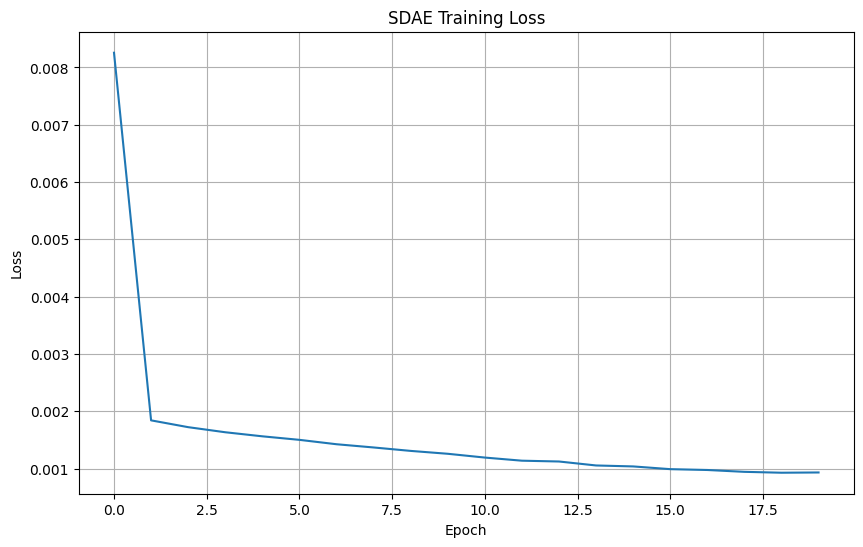


--- Step 2: Generating latent embeddings ---
Generated SDAE embeddings shape: (63001, 64)

--- Step 3: Preparing user-item interaction data ---
Number of users: 192403
Number of items: 63001
Training set size: 1351350
Testing set size: 337838

--- Step 4: Training the NeuMF++ model ---
Epoch [1/20], Loss: 1.366992, RMSE: 1.150451
Epoch [5/20], Loss: 0.163576, RMSE: 0.402581
Epoch [10/20], Loss: 0.079319, RMSE: 0.280922
Epoch [15/20], Loss: 0.053181, RMSE: 0.230109
Epoch [20/20], Loss: 0.040226, RMSE: 0.200194


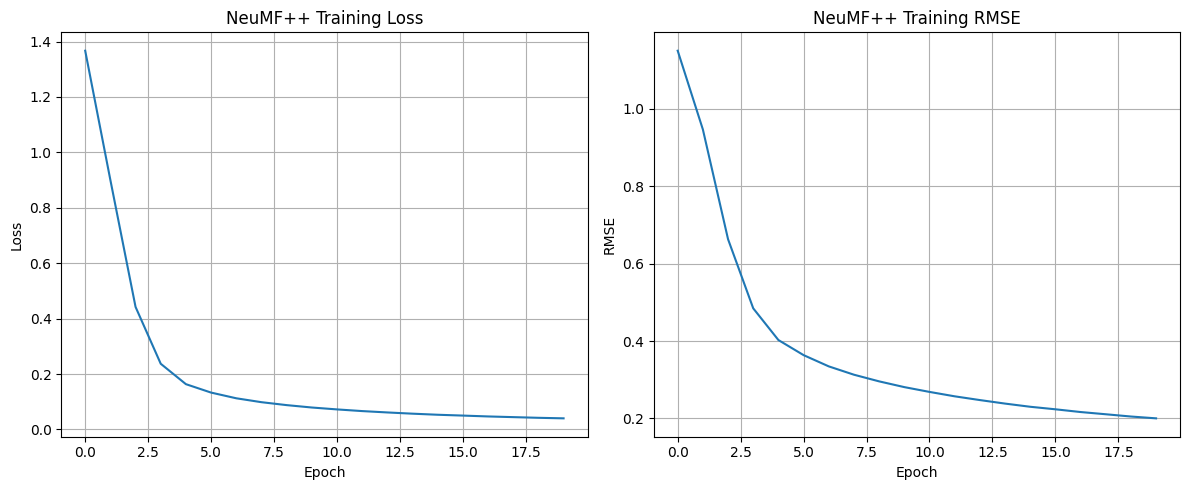


--- Step 5: Evaluating on test data ---
Test RMSE: 1.2483
Test MAE: 0.9400

--- Step 6: Evaluating on cold-start items ---
Average interactions for cold-start items: 1291.3
Cold-Start RMSE: 0.5193
Cold-Start MAE: 0.3054

--- Step 7: Generating sample recommendations ---

Top 5 recommended product IDs for user AO94DHGC771SJ:
1. B0028Y4H1O
2. B003YNQ6MG
3. B009JS61MK
4. B004R6J2V6
5. B002NGVY8G

--- Step 8: Saving models and embeddings ---

Pipeline complete! Models, embeddings, and mappings saved.


In [ ]:
def execute_neumf_pipeline():
    """Run the complete NeuMF++ pipeline with autoencoder embeddings"""
    print("\n" + "="*80)
    print(" NeuMF++ with Autoencoder Embeddings Pipeline ".center(80, "="))
    print("="*80 + "\n")

    # Step 1: Train the SDAE model
    print("\n--- Step 1: Training the Stacked Denoising Autoencoder ---")
    input_dim = product_embeddings.shape[1]
    hidden_dims = [256, 128]
    latent_dim = 64
    dropout_rate = 0.2

    # Create and train SDAE model
    sdae_model = SDAE(input_dim, hidden_dims, latent_dim, dropout_rate)
    sdae_model, sdae_history = train_autoencoder(
        sdae_model,
        product_embeddings,
        batch_size=128,
        num_epochs=20,
        learning_rate=0.001
    )

    # Plot SDAE training loss
    plot_training_history(sdae_history['loss'], 'SDAE Training Loss', 'Loss')

    # Step 2: Generate latent embeddings for all items
    print("\n--- Step 2: Generating latent embeddings ---")
    item_sdae_embeddings = generate_latent_embeddings(sdae_model, product_embeddings)
    print(f"Generated SDAE embeddings shape: {item_sdae_embeddings.shape}")

    # Step 3: Prepare user-item interaction data
    print("\n--- Step 3: Preparing user-item interaction data ---")
    # Create mappings
    mappings = create_user_item_mappings(reviews_df)
    print(f"Number of users: {mappings['num_users']}")
    print(f"Number of items: {mappings['num_items']}")

    # Encode the reviews dataset
    encoded_df = encode_reviews(reviews_df, mappings)

    # Split into training and testing sets
    train_df, test_df = train_test_split(encoded_df, test_size=0.2, random_state=RANDOM_SEED)
    print(f"Training set size: {len(train_df)}")
    print(f"Testing set size: {len(test_df)}")

    # Create datasets and dataloaders
    train_dataset = RatingDataset(train_df)
    test_dataset = RatingDataset(test_df)

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True)

    # Step 4: Train the NeuMF++ model
    print("\n--- Step 4: Training the NeuMF++ model ---")
    embedding_dim = 16
    mlp_layers = [64, 32, 16]

    neumf_model = NeuMFPlusPlus(
        num_users=mappings['num_users'],
        num_items=mappings['num_items'],
        embedding_dim=embedding_dim,
        latent_dim=latent_dim,
        layers=mlp_layers
    )

    neumf_model, neumf_history = train_neumf_plus_plus(
        neumf_model,
        train_dataloader,
        item_sdae_embeddings,
        epochs=20,
        learning_rate=0.001
    )

    # Plot NeuMF++ training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(neumf_history['loss'])
    plt.title('NeuMF++ Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(neumf_history['rmse'])
    plt.title('NeuMF++ Training RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('neumf_training_history.png')
    plt.show()

    # Step 5: Evaluate the model
    print("\n--- Step 5: Evaluating on test data ---")
    metrics = evaluate_model(neumf_model, test_dataloader, item_sdae_embeddings)
    print(f"Test RMSE: {metrics['RMSE']:.4f}")
    print(f"Test MAE: {metrics['MAE']:.4f}")

    # Step 6: Evaluate on cold-start items
    print("\n--- Step 6: Evaluating on cold-start items ---")
    cold_start_metrics = evaluate_cold_start(
        reviews_df,
        neumf_model,
        mappings,
        item_sdae_embeddings,
        n_cold_items=100
    )

    # Step 7: Generate recommendations for a sample user
    print("\n--- Step 7: Generating sample recommendations ---")
    # Choose a random user ID from the dataset
    sample_user_id = reviews_df['reviewerID'].iloc[0]

    # Generate recommendations (only product IDs)
    top_recommendations = generate_recommendations(
        neumf_model,
        sample_user_id,
        mappings,
        item_sdae_embeddings,
        top_k=5
    )

    print(f"\nTop 5 recommended product IDs for user {sample_user_id}:")
    for i, product_id in enumerate(top_recommendations):
        print(f"{i+1}. {product_id}")

    # Step 8: Save models and embeddings
    print("\n--- Step 8: Saving models and embeddings ---")
    save_path = 'models'
    os.makedirs(save_path, exist_ok=True)

    torch.save(sdae_model.state_dict(), os.path.join(save_path, 'sdae_model.pth'))
    torch.save(neumf_model.state_dict(), os.path.join(save_path, 'neumf_model.pth'))
    np.save(os.path.join(save_path, 'item_sdae_embeddings.npy'), item_sdae_embeddings)

    # Save mappings for future use
    import pickle
    with open(os.path.join(save_path, 'mappings.pkl'), 'wb') as f:
        pickle.dump(mappings, f)

    print("\nPipeline complete! Models, embeddings, and mappings saved.")

    return {
        'sdae_model': sdae_model,
        'neumf_model': neumf_model,
        'item_sdae_embeddings': item_sdae_embeddings,
        'mappings': mappings,
        'metrics': metrics,
        'cold_start_metrics': cold_start_metrics,
        'sdae_history': sdae_history,
        'neumf_history': neumf_history
    }

# Add a final cell to execute the pipeline
if __name__ == "__main__":
    results = execute_neumf_pipeline()

In [ ]:
# First, fix the evaluate_cold_start function with the correction
def evaluate_cold_start_fixed(reviews_df, model, mappings, item_sdae_embeddings, n_cold_items=100):
    """Evaluate the model's performance on cold-start items."""
    # Count interactions per item
    item_counts = reviews_df['asin'].value_counts().reset_index()
    item_counts.columns = ['asin', 'count']

    # Identify cold-start items (those with few interactions)
    cold_start_df = item_counts.sort_values('count').head(n_cold_items)
    cold_start_items = cold_start_df['asin'].values

    # Calculate the correct average
    print(f"Average interactions for cold-start items: {cold_start_df['count'].mean():.1f}")

    # Filter reviews for cold-start items
    cold_start_reviews = reviews_df[reviews_df['asin'].isin(cold_start_items)].copy()

    # Encode cold start reviews
    cold_start_reviews['user_idx'] = cold_start_reviews['reviewerID'].map(mappings['user_to_idx'])
    cold_start_reviews['item_idx'] = cold_start_reviews['asin'].map(mappings['item_to_idx'])

    # Create dataset and dataloader
    cold_start_dataset = RatingDataset(cold_start_reviews)
    cold_start_dataloader = DataLoader(cold_start_dataset, batch_size=128, shuffle=False)

    # Evaluate model on cold-start items
    model.eval()
    item_sdae_embeddings_tensor = torch.FloatTensor(item_sdae_embeddings).to(device)

    all_predictions = []
    all_ratings = []

    with torch.no_grad():
        for user_indices, item_indices, ratings in cold_start_dataloader:
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)

            # Forward pass
            predictions = model(user_indices, item_indices, item_sdae_embeddings_tensor).squeeze()

            # Store predictions and ratings
            all_predictions.extend(predictions.cpu().numpy())
            all_ratings.extend(ratings.numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_ratings = np.array(all_ratings)

    # Calculate metrics
    rmse = np.sqrt(np.mean((all_predictions - all_ratings) ** 2))
    mae = np.mean(np.abs(all_predictions - all_ratings))

    print(f"Cold-Start RMSE: {rmse:.4f}")
    print(f"Cold-Start MAE: {mae:.4f}")

    return {
        'cold_start_rmse': rmse,
        'cold_start_mae': mae,
        'num_cold_items': n_cold_items
    }

# Now you can run this function with your existing trained model
cold_start_metrics_fixed = evaluate_cold_start_fixed(
    reviews_df,
    results["neumf_model"],  # Your already trained model
    results["mappings"],      # Your existing mappings
    results["item_sdae_embeddings"],  # Your existing embeddings
    n_cold_items=100
)

Average interactions for cold-start items: 5.0
Cold-Start RMSE: 0.5193
Cold-Start MAE: 0.3054
